Importação de bibliotecas

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

Carregamento dos dados

In [2]:
df = pd.read_json('https://api.openligadb.de/getmatchdata/wwc/2023')

Select das colunas que interessam

In [3]:
df = df[['group', 'team1', 'team2', 'goals', 'matchResults']]
df.head()

,group,team1,team2,goals,matchResults
0,"{'groupName': 'Group Matches 1', 'groupOrderID...","{'teamId': 6031, 'teamName': 'Neuseeland Fraue...","{'teamId': 6032, 'teamName': 'Norwegen Frauen'...","[{'goalID': 102009, 'scoreTeam1': 1, 'scoreTea...","[{'resultID': 103096, 'resultName': 'Halbzeit'..."
1,"{'groupName': 'Group Matches 1', 'groupOrderID...","{'teamId': 6035, 'teamName': 'Australien Fraue...","{'teamId': 6038, 'teamName': 'Irland Frauen', ...","[{'goalID': 102010, 'scoreTeam1': 1, 'scoreTea...","[{'resultID': 103097, 'resultName': 'Halbzeit'..."
2,"{'groupName': 'Group Matches 1', 'groupOrderID...","{'teamId': 6037, 'teamName': 'Nigeria Frauen',...","{'teamId': 6036, 'teamName': 'Kanada Frauen', ...",[],"[{'resultID': 103099, 'resultName': 'Halbzeit'..."
3,"{'groupName': 'Group Matches 1', 'groupOrderID...","{'teamId': 6033, 'teamName': 'Philippinen Frau...","{'teamId': 6034, 'teamName': 'Schweiz Frauen',...","[{'goalID': 102015, 'scoreTeam1': 0, 'scoreTea...","[{'resultID': 103101, 'resultName': 'Halbzeit'..."
4,"{'groupName': 'Group Matches 1', 'groupOrderID...","{'teamId': 6057, 'teamName': 'Spanien Frauen',...","{'teamId': 6043, 'teamName': 'Costa Rica Fraue...","[{'goalID': 102017, 'scoreTeam1': 1, 'scoreTea...","[{'resultID': 103103, 'resultName': 'Halbzeit'..."


- _Normalize_ das colunas json: team1, team2, goals
- _Explode_ da coluna goals por ter **n** "json" dentro de cada registro
- _Merge_ dos dataframes adicionando prefixo nas colunas explodidas

In [4]:
df_team1 = pd.json_normalize(df['team1'])
df_team2 = pd.json_normalize(df['team2'])
df_group = pd.json_normalize(df['group'])

df_goals = df['goals'].explode().apply(lambda x: pd.Series(x) if x is not None else pd.Series())

df2 = pd.concat([df.drop(['group', 'team1', 'team2', 'goals'], axis=1).reset_index(drop=True), df_group.add_prefix('group_'), df_team1.add_prefix('team1_'), df_team2.add_prefix('team2_'), df_goals.add_prefix('goal_')], axis=1)


Select das colunas interessantes

In [6]:
filtered_df_1 = df2[['group_groupName', 'team1_shortName', 'team2_shortName', 'goal_goalID', 'goal_scoreTeam1', 'goal_scoreTeam2', 'goal_isPenalty', 'goal_matchMinute']]


Filtro de Eliminatórias

In [7]:
filtered_df_2 = filtered_df_1[filtered_df_1['group_groupName'].isin(['Semifinals', 'Final', 'Round of 16', 'Quarterfinals'])]
filtered_df_2.head()

,group_groupName,team1_shortName,team2_shortName,goal_goalID,goal_scoreTeam1,goal_scoreTeam2,goal_isPenalty,goal_matchMinute
48,Round of 16,CHE,ESP,102202.0,0.0,1.0,False,NaN
48,Round of 16,CHE,ESP,102203.0,1.0,1.0,False,NaN
48,Round of 16,CHE,ESP,102204.0,1.0,2.0,False,NaN
48,Round of 16,CHE,ESP,102205.0,1.0,3.0,False,NaN
48,Round of 16,CHE,ESP,102206.0,1.0,4.0,False,NaN


- Filtro para pegar somente os gols não marcados por pênalti
- Preenchimento dos campos NaN com 0

In [8]:

filtered_df_3 = filtered_df_2.loc[filtered_df_2['goal_isPenalty'] == False, ['team1_shortName', 'team2_shortName', 'goal_scoreTeam1', 'goal_scoreTeam2']]
filtered_df_3 = filtered_df_3.fillna(0)

In [11]:
#filtered_df_3 = filtered_df_3.loc[(filtered_df_3['goal_scoreTeam1'] != 0) & (filtered_df_3['goal_scoreTeam2'] != 0)]


In [12]:
filtered_df_3.head(20)

,team1_shortName,team2_shortName,goal_scoreTeam1,goal_scoreTeam2
48,CHE,ESP,0.0,1.0
48,CHE,ESP,1.0,1.0
48,CHE,ESP,1.0,2.0
48,CHE,ESP,1.0,3.0
48,CHE,ESP,1.0,4.0
48,CHE,ESP,1.0,5.0
49,JPN,NOR,1.0,0.0
49,JPN,NOR,1.0,1.0
49,JPN,NOR,2.0,1.0
49,JPN,NOR,3.0,1.0


Count Distinct dos campos de goals e agrupamento dos registros combinados de ['team1_shortName', 'team2_shortName'], aqui foi colocado um filtro para o "gol 0" não ser contabilizado no distinct

In [15]:
def count_unique_nonzero(series):
    return series[series != 0].nunique()

count_distinct = filtered_df_3.groupby(['team1_shortName', 'team2_shortName']).agg({
    'goal_scoreTeam1': count_unique_nonzero,
    'goal_scoreTeam2': count_unique_nonzero
}).reset_index()

In [16]:
count_distinct.head(20)

,team1_shortName,team2_shortName,goal_scoreTeam1,goal_scoreTeam2
0,AUS,DNK,2,0
1,AUS,ENG,1,3
2,AUS,FRA,6,5
3,CHE,ESP,1,5
4,COL,JAM,1,0
5,ENG,COL,2,1
6,ENG,NIG,1,1
7,ESP,ENG,1,0
8,ESP,NED,2,1
9,ESP,SWE,2,1


Separação dos campos 1 e 2

In [17]:
df_team1 = count_distinct[['team1_shortName', 'goal_scoreTeam1']].rename(columns={'team1_shortName':'team', 'goal_scoreTeam1': 'goals'})
df_team2 = count_distinct[['team2_shortName', 'goal_scoreTeam2']].rename(columns={'team2_shortName':'team', 'goal_scoreTeam2': 'goals'})

Operação de Union dos dois dataframes

In [18]:
result = pd.concat([df_team1, df_team2])
result = result.groupby('team')['goals'].sum()
result.head(16)

team
AUS     9
CHE     1
COL     2
DNK     0
ENG     6
ESP    10
FRA     9
JAM     0
JPN     4
MAR     0
NED     3
NIG     1
NOR     1
RSA     0
SWE     9
USA     4
Name: goals, dtype: int64

Transformação do resultado em dicionário, aggrupamento das seleções com o mesmo número de gols e sort no dicionário

In [19]:
from collections import defaultdict

df_dict = result.to_dict()
grouped_data = defaultdict(list)
for team, goals in df_dict.items():
    grouped_data[goals].append(team)
    
sorted_grouped_data = sorted(grouped_data.items())



Configurações do plot do gráfico

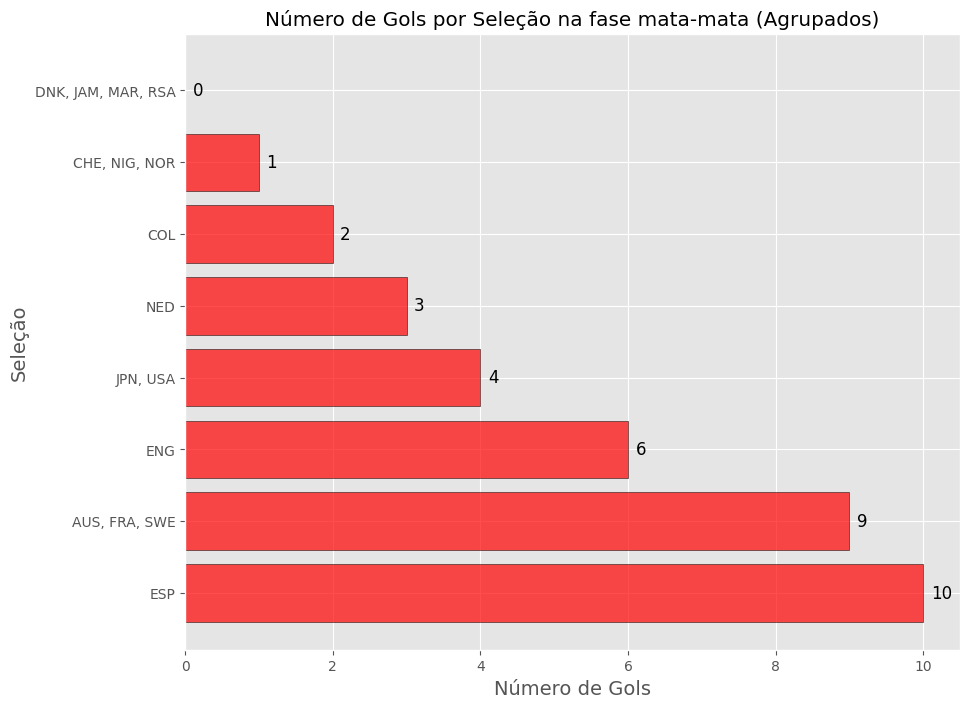

In [37]:
labels = []
values = []
for goals, teams in sorted_grouped_data:
    labels.append(', '.join(teams))
    values.append(goals)

plt.style.use('ggplot')

plt.figure(figsize=(10, 8))
bars = plt.barh(labels, values, color='red', edgecolor='black', alpha=0.7)
plt.xlabel('Número de Gols', fontsize=14)
plt.ylabel('Seleção', fontsize=14)
plt.title('Número de Gols por Seleção na fase mata-mata (Agrupados)')
plt.gca().invert_yaxis() 


# Add valores nas barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2, str(width), va='center', fontsize=12, color='black')


plt.show()